In [1]:
import sys
print(sys.executable)

/Users/premaimmadisetty/Documents/BIOSTAT625_Project/.venv/bin/python


In [3]:
import pandas as pd
import os

DATA_DIR = os.path.join("data", "ptbxl")
csv_path = os.path.join(DATA_DIR, "ptbxl_database.csv")

df = pd.read_csv(csv_path)
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [4]:
import wfdb
import matplotlib.pyplot as plt
import os

# pick the first ECG in the dataset
row = df.iloc[0]

# build the full path to the ECG waveform file
ecg_path = os.path.join("data", "ptbxl", row["filename_hr"])

print("Loading ECG from:", ecg_path)

# load the waveform (signal) and metadata
signal, meta = wfdb.rdsamp(ecg_path)

print("Signal shape:", signal.shape)
signal[:5]

Loading ECG from: data/ptbxl/records500/00000/00001_hr
Signal shape: (5000, 12)


array([[-0.115, -0.05 ,  0.065,  0.082, -0.09 ,  0.007, -0.065, -0.04 ,
        -0.005, -0.035, -0.035, -0.075],
       [-0.115, -0.05 ,  0.065,  0.082, -0.09 ,  0.007, -0.065, -0.04 ,
        -0.005, -0.035, -0.035, -0.075],
       [-0.115, -0.05 ,  0.065,  0.082, -0.09 ,  0.007, -0.065, -0.04 ,
        -0.005, -0.035, -0.035, -0.075],
       [-0.115, -0.05 ,  0.065,  0.082, -0.09 ,  0.007, -0.065, -0.04 ,
        -0.005, -0.035, -0.035, -0.075],
       [-0.115, -0.05 ,  0.065,  0.082, -0.09 ,  0.007, -0.065, -0.04 ,
        -0.005, -0.035, -0.035, -0.075]])

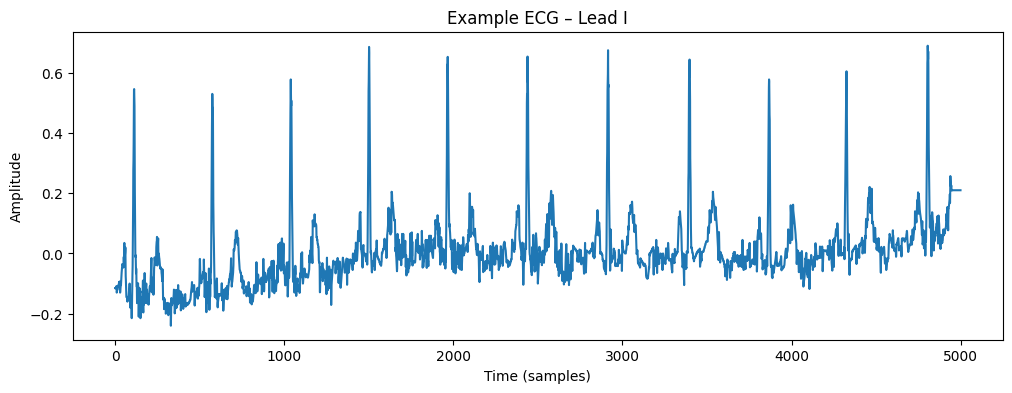

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(signal[:, 0])  # Lead I
plt.title("Example ECG – Lead I")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


In [6]:
import numpy as np

def normalize_signal(sig):
    return (sig - np.mean(sig, axis=0)) / np.std(sig, axis=0)

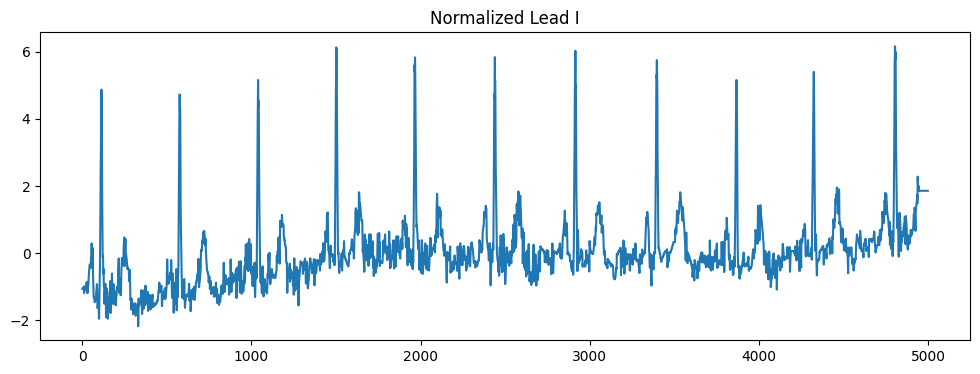

In [7]:
norm_signal = normalize_signal(signal)
plt.figure(figsize=(12,4))
plt.plot(norm_signal[:,0])
plt.title("Normalized Lead I")
plt.show()

In [8]:
from scipy.signal import butter, filtfilt

def bandpass_filter(sig, low=0.5, high=40, fs=500):
    b, a = butter(1, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, sig, axis=0)

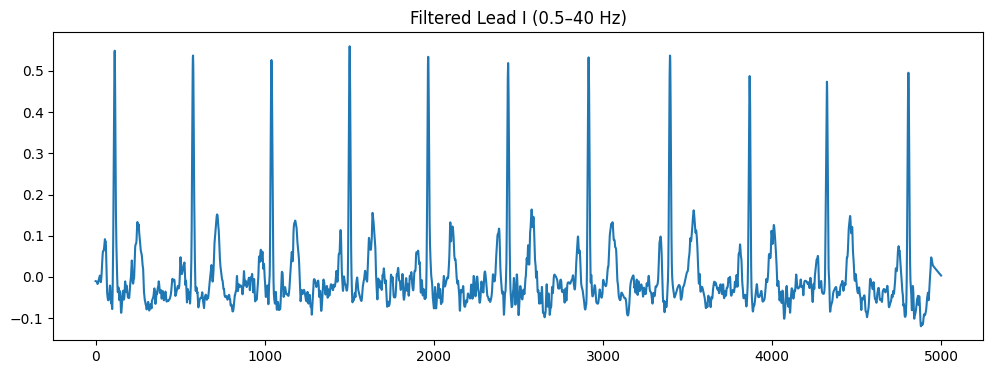

In [9]:
filt_signal = bandpass_filter(signal)
plt.figure(figsize=(12,4))
plt.plot(filt_signal[:,0])
plt.title("Filtered Lead I (0.5–40 Hz)")
plt.show()

In [10]:
def preprocess(sig):
    sig = bandpass_filter(sig)
    sig = normalize_signal(sig)
    return sig

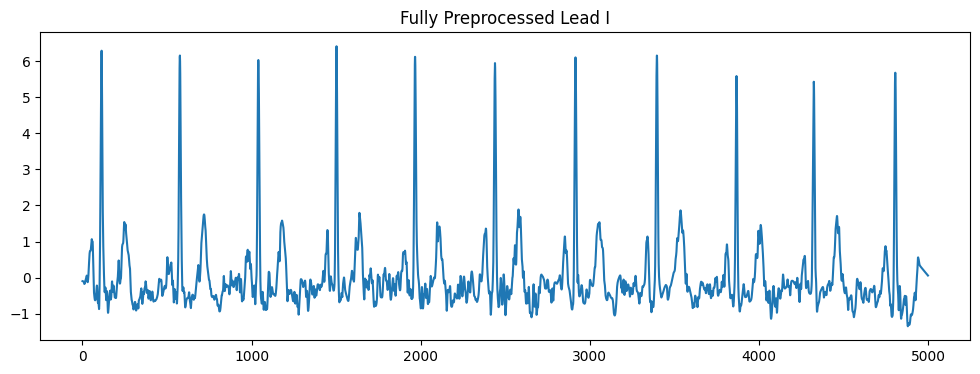

In [11]:
clean = preprocess(signal)

plt.figure(figsize=(12,4))
plt.plot(clean[:,0])
plt.title("Fully Preprocessed Lead I")
plt.show()

In [12]:
df[['filename_hr', 'diagnostic_superclass']].head()

KeyError: "['diagnostic_superclass'] not in index"

In [13]:
df.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [17]:
import os
import pandas as pd
import ast

# Load scp_statements.csv
scp_path = os.path.join("data", "ptbxl", "scp_statements.csv")
scp = pd.read_csv(scp_path)

# Keep only rows where diagnostic_class is not empty
scp_diag = scp[scp['diagnostic_class'].notna()]

# Build mapping: scp_code (in 'Unnamed: 0') -> diagnostic_class
diag_map = scp_diag.set_index('Unnamed: 0')['diagnostic_class'].to_dict()

len(diag_map), list(diag_map.items())[:10]

(44,
 [('NDT', 'STTC'),
  ('NST_', 'STTC'),
  ('DIG', 'STTC'),
  ('LNGQT', 'STTC'),
  ('NORM', 'NORM'),
  ('IMI', 'MI'),
  ('ASMI', 'MI'),
  ('LVH', 'HYP'),
  ('LAFB', 'CD'),
  ('ISC_', 'STTC')])

In [18]:
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_codes'].iloc[0]

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

In [19]:
def get_superclass_from_scp_codes(row):
    codes = row['scp_codes'].keys()
    classes = [diag_map[c] for c in codes if c in diag_map]
    if len(classes) == 0:
        return None  # no diagnostic class found
    return classes[0]  # just pick the first mapped class

df['diagnostic_superclass'] = df.apply(get_superclass_from_scp_codes, axis=1)

df['diagnostic_superclass'].value_counts()


diagnostic_superclass
NORM    9514
MI      5424
STTC    2817
CD      2325
HYP     1308
Name: count, dtype: int64

In [20]:
label_map = {
    'NORM': 0,
    'MI': 1,
    'STTC': 2,
    'CD': 3,
    'HYP': 4
}

df['label'] = df['diagnostic_superclass'].map(label_map)
df['label'].value_counts(dropna=False)

label
0.0    9514
1.0    5424
2.0    2817
3.0    2325
4.0    1308
NaN     411
Name: count, dtype: int64

In [21]:
df_model = df[df['label'].notna()].copy()
df_model.shape

(21388, 30)

In [22]:
subset = df_model.iloc[:200]   # first 200 ECGs
subset[['filename_hr', 'diagnostic_superclass', 'label']].head()

,filename_hr,diagnostic_superclass,label
0,records500/00000/00001_hr,NORM,0.0
1,records500/00000/00002_hr,NORM,0.0
2,records500/00000/00003_hr,NORM,0.0
3,records500/00000/00004_hr,NORM,0.0
4,records500/00000/00005_hr,NORM,0.0


In [23]:
import os
import wfdb

def load_ecg_from_row(row):
    path = os.path.join("data", "ptbxl", row["filename_hr"])
    sig, meta = wfdb.rdsamp(path)
    sig = preprocess(sig)   # bandpass + normalize
    return sig

In [24]:
X = []
y = []

for idx, row in subset.iterrows():
    sig = load_ecg_from_row(row)
    X.append(sig)
    y.append(int(row["label"]))  # cast to int

len(X), len(y)


(200, 200)

In [25]:
import numpy as np

X = np.array(X)
y = np.array(y, dtype=int)

X.shape, y.shape

((200, 5000, 12), (200,))

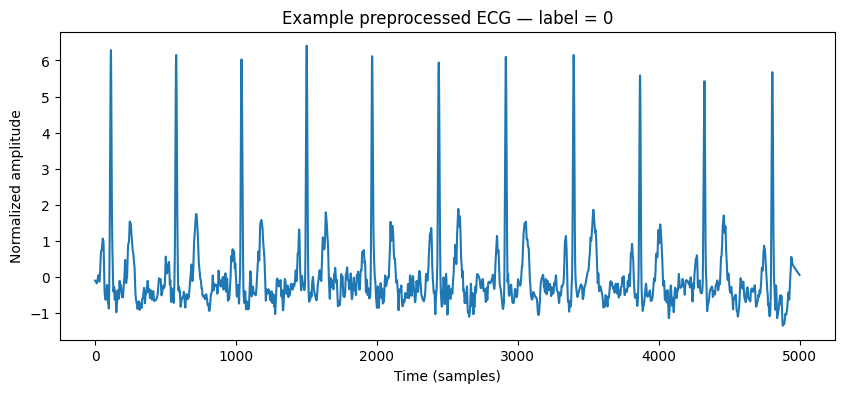

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(X[0][:, 0])
plt.title(f"Example preprocessed ECG — label = {y[0]}")
plt.xlabel("Time (samples)")
plt.ylabel("Normalized amplitude")
plt.show()

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((160, 5000, 12), (40, 5000, 12), (160,), (40,))

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (5000, 12)   # (time, leads)

model = models.Sequential([
    layers.Conv1D(32, kernel_size=7, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(64, kernel_size=7, activation='relu'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=7, activation='relu'),
    layers.MaxPooling1D(pool_size=2),

    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')   # 5 classes: 0..4
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/Users/premaimmadisetty/Documents/BIOSTAT625_Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/premaimmadisetty/Documents/BIOSTAT625_Project/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4994, 32)       │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2497, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2491, 64)       │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1245, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1239, 128)      │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 619, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,173 (324.89 KB)

 Trainable params: 83,173 (324.89 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5435 - loss: 1.2805 - val_accuracy: 0.6750 - val_loss: 1.0340
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6417 - loss: 1.0916 - val_accuracy: 0.6750 - val_loss: 1.0091
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6488 - loss: 1.0469 - val_accuracy: 0.6750 - val_loss: 0.9743
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6833 - loss: 0.9119 - val_accuracy: 0.6750 - val_loss: 0.9405
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7248 - loss: 0.8989 - val_accuracy: 0.6750 - val_loss: 0.9422
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6944 - loss: 0.9066 - val_accuracy: 0.6750 - val_loss: 0.8987
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6991 - loss: 0.9121 - val_accuracy: 0.6750 - val_loss: 0.8776
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7164 - loss: 0.8939 - val_accuracy: 0.6750 - v

In [30]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7125 - loss: 0.9124
Validation loss: 0.8769953846931458
Validation accuracy: 0.7250000238418579


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

print("Classification report:")
print(classification_report(y_val, y_val_pred))

print("Confusion matrix:")
print(confusion_matrix(y_val, y_val_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.89        27
           1       0.33      0.40      0.36         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1

    accuracy                           0.72        40
   macro avg       0.23      0.28      0.25        40
weighted avg       0.58      0.72      0.64        40

Confusion matrix:
[[27  0  0  0  0]
 [ 3  2  0  0  0]
 [ 2  2  0  0  0]
 [ 1  2  0  0  0]
 [ 1  0  0  0  0]]


/Users/premaimmadisetty/Documents/BIOSTAT625_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/premaimmadisetty/Documents/BIOSTAT625_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/premaimmadisetty/Documents/BIOSTAT625_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont